In [76]:
import matplotlib.pyplot as plt
import numpy as np

import torch

# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic

from reaction_diffusion import OneDimensionalRDEquations, random_periodic

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
Da, Db, alpha, beta = 10, 10, -0.4, 1

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 100
dx = 1
dt = 0.01

In [78]:
solution = OneDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    width=width, dx=dx, dt=dt, 
    steps=300,  initialiser=random_periodic
)

In [79]:
solution.initialise()
solution.make_grid()
solution.update()

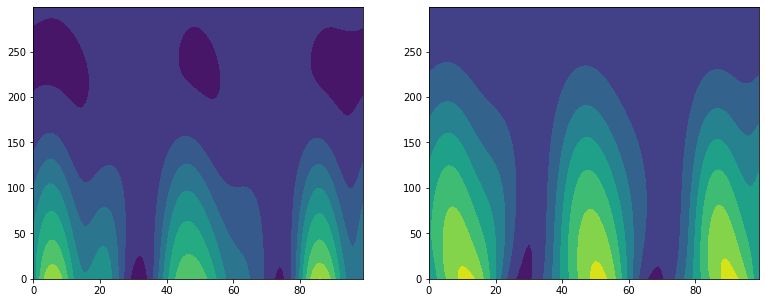

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,5))
ax1.contourf(np.array(solution.Ya))
ax2.contourf(np.array(solution.Yb))

In [81]:
x_grid, t_grid = solution.x_grid/np.max(solution.x_grid), solution.t_grid/np.max(solution.t_grid)

In [82]:
y1, y2 = np.array(solution.Ya).T.flatten(), np.array(solution.Yb).T.flatten()

In [83]:
X = np.transpose((t_grid.flatten(), x_grid.flatten()))
y = np.transpose((y1/np.max(y1),  y2/np.max(y2)))

In [84]:
number_of_samples = 10000
idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32).to(device)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32).to(device)

In [85]:
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

class Library_custom(Library):
    """[summary]

    Args:
        Library ([type]): [description]
    """
    def __init__(self) -> None:
        super().__init__()

    def library(self, input: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[TensorList, TensorList]:
    
        prediction, data = input
        samples = prediction.shape[0]
        poly_list = []
        deriv_list = []
        time_deriv_list = []
        
        
        # Construct the theta matrix
        C = torch.ones_like(prediction[:,0]).view(samples, -1)
        u = prediction[:,0].view(samples, -1)
        v = prediction[:,1].view(samples, -1)
        
        du = grad(u, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = du[:, 1:2]
        dux = grad(u_x, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = dux[:, 1:2]
        
        dv = grad(v, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = dv[:, 1:2]
        dvx = grad(v_x, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_xx = dvx[:, 1:2]
        
        theta = torch.cat((C, u, u*u, u*u*u, v, v*v, v*v*v, u_x, u_xx, v_x, v_xx),dim=1)
        
        
        
        # Construct a list of time_derivatives 
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True)[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)
        
        return time_deriv_list, [theta,theta]

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [100]:
network = Siren(2, [50, 50, 50,50], 2)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [101]:
library = Library_custom() 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [102]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [103]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [104]:
model = DeepMoD(network, library, estimator, constraint).to(device)

In [106]:
# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2.5e-4) 

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [107]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/Reaction/', split=0.8, max_iterations=100000, delta=2.5e-7, patience=10) 

  4450  MSE: 3.30e-05  Reg: 1.71e-05  L1: 8.10e+00 Algorithm converged. Writing model to disk.
